# Import Packages and Dataset 
# Data Assessment and Cleaning

# Problem Statement
Build a predictive model to understand and predict patients adherance to treatment. This can help healthcare industries understand patients reactions to Anti-retro viral therapy (ART), and also to understand factors that will probably affect patient response to ART treatment.

In [116]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import pickle

In [2]:
# Read data file and explore
data = pd.read_excel(r'C:\Users\hp\Downloads\Copy of HIVAIDS Dataset.xlsx')
print(data['Current ART Status'].value_counts())
print(data.isnull().sum())
print(data.shape)

Current ART Status
Active             4781
LTFU                  9
Transferred out       3
Name: count, dtype: int64
Patient Unique ID                           0
ID                                          2
Patient Hospital No                         7
Sex                                         0
Age at Start of ART(Years)                  0
Age at Start of ART(Months)              4793
ART Start Date                              0
Last Pickup Date                            0
DaysOfARVRefil                              0
Regimen Line at ART Start                   0
Regimen at ART Start                        0
Current Regimen Line                        0
Current ART Regimen                         0
Pregnancy Status                         4322
Current Viral Load (c/ml)                3643
Date of Current Viral Load (dd/mm/yy)    3643
Viral Load Indication                    3010
Current ART Status                          0
CurrentAge(Years)                           0
CurrentAg

In [3]:
# Calculating percentage null values to determine columns to drop
columns = []
for cols in list(data.columns):
    null_count = data[cols].isnull().sum()
    per_null = int(round((null_count/len(data[cols])) * 100, 0))
    columns.append(f'{cols}:{per_null}%')

df = pd.DataFrame(columns, columns=['Column_Name : Null_Percentage']) # create dataframe for percentage null values
df[['columns', 'Null Percentage']] = df['Column_Name : Null_Percentage'].str.split(':', expand = True) # split into different columns 

In [4]:
df = df.drop('Column_Name : Null_Percentage', axis = 1)

In [5]:
df['Null Percentage'] = df['Null Percentage'].str.replace('%', '')

In [6]:
df['Null Percentage'] = df['Null Percentage'].astype('int64')

In [7]:
df1 = df[df['Null Percentage'] > 50]

In [8]:
columns_to_drop = list(df1['columns'].values)

data.drop(columns_to_drop, axis = 1, inplace = True) # drop columns having greater than 50% null values 

In [9]:
data.drop(data.columns[0], axis = 1, inplace = True) # drop irrelevant Patient Unique ID column after anonymization

In [10]:
# Check for datatypes
data.dtypes

ID                            object
Patient Hospital No           object
Sex                           object
Age at Start of ART(Years)     int64
ART Start Date                object
Last Pickup Date              object
DaysOfARVRefil                 int64
Regimen Line at ART Start     object
Regimen at ART Start          object
Current Regimen Line          object
Current ART Regimen           object
Current ART Status            object
CurrentAge(Years)              int64
DateOfBirth                   object
dtype: object

In [11]:
columns =  ['ART Start Date', 'Last Pickup Date', 'DateOfBirth'] # convert these columns to datetime datatype
for col in columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
 

In [12]:
data.dtypes

ID                                    object
Patient Hospital No                   object
Sex                                   object
Age at Start of ART(Years)             int64
ART Start Date                datetime64[ns]
Last Pickup Date              datetime64[ns]
DaysOfARVRefil                         int64
Regimen Line at ART Start             object
Regimen at ART Start                  object
Current Regimen Line                  object
Current ART Regimen                   object
Current ART Status                    object
CurrentAge(Years)                      int64
DateOfBirth                   datetime64[ns]
dtype: object

# Exploratory Data Analysis

In [13]:
data = data[['ID', 'Patient Hospital No', 'Sex', 'Age at Start of ART(Years)',
       'ART Start Date', 'Last Pickup Date', 'DaysOfARVRefil',
       'Regimen Line at ART Start', 'Regimen at ART Start',
       'Current Regimen Line', 'Current ART Regimen', 
       'CurrentAge(Years)', 'DateOfBirth','Current ART Status']]

Sex
M    4316
F     477
Name: count, dtype: int64


<Axes: xlabel='Current ART Status'>

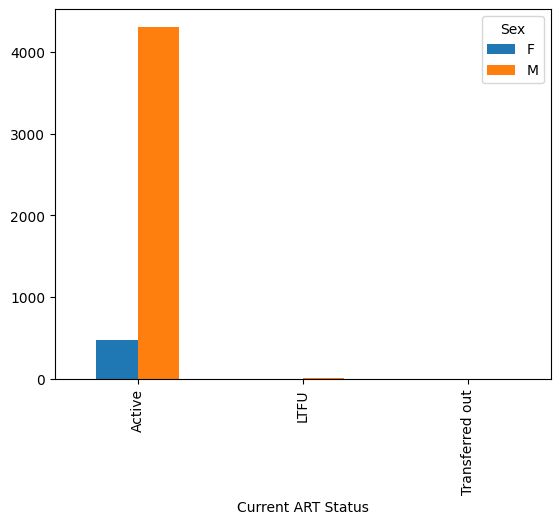

In [14]:
# Understanding distribution of current ART status by male and female
print(data['Sex'].value_counts())
data.groupby(['Current ART Status', 'Sex']).size().unstack().plot(kind = 'bar')

In [60]:
# Understanding Age bin of people undergoing ART 
bins = [9, 10, data['CurrentAge(Years)'].max()]
labels = ['Child', 'Adult']
data['Age Group'] = pd.cut(data['CurrentAge(Years)'], bins = bins, labels = labels) # group age data

<Axes: ylabel='Frequency'>

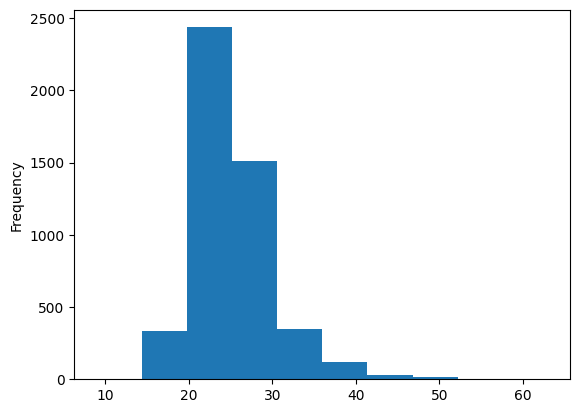

In [16]:
data['CurrentAge(Years)'].plot(kind = 'hist')

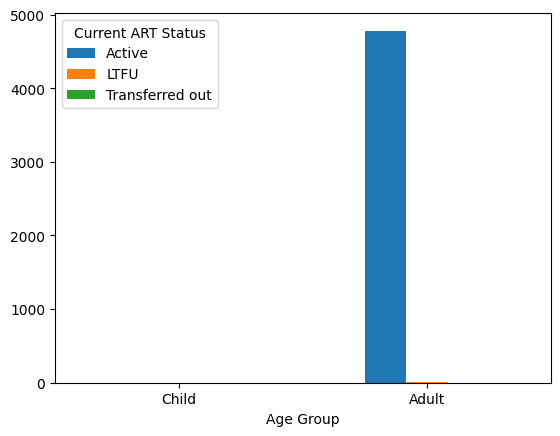

In [61]:
data.groupby(['Age Group', 'Current ART Status']).size().unstack().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

# Model Development 

In [ ]:
# Selecting best features correlation to target variable "Current ART Status"
data1 = data.copy() # make a copy of the dataset
x = data1
y = data1.pop('Current ART Status')

In [32]:
# Encoding Categorical variables
for col in x.select_dtypes('O'):
    x[col],_ = x[col].factorize()

In [40]:
# Encoding y variable
y,_ = y.factorize()

Note: This is not the encoding for building the random forest classifier model

In [ ]:
data1.isnull().sum()
data1['Age Group'].fillna(data1['Age Group'].mode(), inplace = True)

data1['Age Group'] = data1['Age Group'].astype('O')

<Axes: >

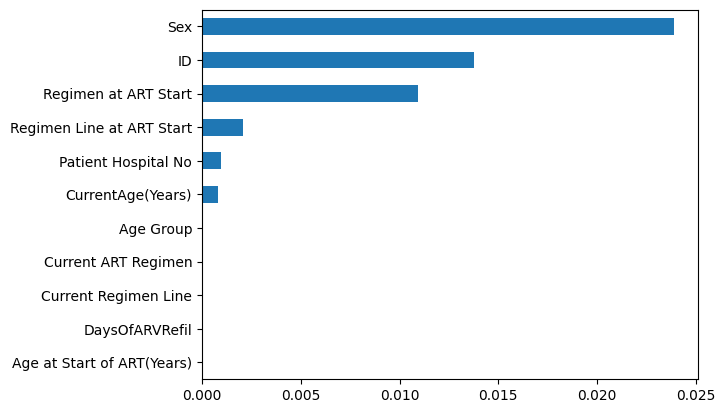

In [62]:
# Building Mutual Regression Model
x = x.select_dtypes('int64')
mi_scores = mutual_info_regression(x,y, random_state = 0)
mi_scores = pd.Series(mi_scores, index = x.columns)
best_features = mi_scores.sort_values(ascending = False).head(14)

# Show features relationship to target variable
best_features.sort_values(ascending = True).plot(kind = 'barh')

So, above is a visual showing the correlation between different features and the target feature

# Feature Encoding 

In [72]:
data.select_dtypes('object').columns
Encode_cols = ['Sex', 'Regimen Line at ART Start',
       'Regimen at ART Start', 'Current Regimen Line', 'Current ART Regimen',
       'Current ART Status', 'Age Group']

In [73]:
# Show Cardinality of the categorical variable to determine the type of encoding 
for col in Encode_cols:
    print(data[col].value_counts(), '\n')

Sex
M    4316
F     477
Name: count, dtype: int64 

Regimen Line at ART Start
Adult 1st line ARV regimen    4787
Child 1st line ARV regimen       6
Name: count, dtype: int64 

Regimen at ART Start
TDF-3TC-DTG    4751
TDF-3TC-EFV      32
TDF-FTC-DTG       9
ABC-3TC-NVP       1
Name: count, dtype: int64 

Current Regimen Line
Adult 1st line ARV regimen    4784
Child 1st line ARV regimen       7
Adult 2nd line ARV regimen       1
Child 2nd line ARV regimen       1
Name: count, dtype: int64 

Current ART Regimen
TDF-3TC-DTG    4755
TDF-3TC-EFV      33
TDF-FTC-DTG       4
ABC-3TC-NVP       1
Name: count, dtype: int64 

Current ART Status
Active             4781
LTFU                  9
Transferred out       3
Name: count, dtype: int64 

Age Group
Adult    4792
Child       1
Name: count, dtype: int64 



In [54]:
data.columns

Index(['ID', 'Patient Hospital No', 'Sex', 'Age at Start of ART(Years)',
       'ART Start Date', 'Last Pickup Date', 'DaysOfARVRefil',
       'Regimen Line at ART Start', 'Regimen at ART Start',
       'Current Regimen Line', 'Current ART Regimen', 'CurrentAge(Years)',
       'DateOfBirth', 'Current ART Status', 'Age Group'],
      dtype='object')

In [71]:
#data[['Regimen Line at ART Start', 'Current Regimen Line', 'CurrentAge(Years)']]
data[data['CurrentAge(Years)']<= 16]

,ID,Patient Hospital No,Sex,Age at Start of ART(Years),ART Start Date,Last Pickup Date,DaysOfARVRefil,Regimen Line at ART Start,Regimen at ART Start,Current Regimen Line,Current ART Regimen,CurrentAge(Years),DateOfBirth,Current ART Status,Age Group
526,Anon/WW//0037,77/06/20M/RYPCAF,M,8,2020-06-08,2020-06-22,90,Child 1st line ARV regimen,ABC-3TC-NVP,Child 2nd line ARV regimen,ABC-3TC-NVP,9,2012-01-01,Transferred out,Child
686,Anon/WW//0087,390/06/20M/RYPCAF,M,15,2020-06-25,2021-03-12,168,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2005-01-01,Active,Adult
892,Anon/WW//0075,238/7/20M/RYPCAF,M,15,2020-07-16,2020-10-13,180,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2005-01-01,Active,Adult
1717,Anon/WW//0052,343/09/20M/RYPCAF,M,16,2020-09-15,2021-03-05,90,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2004-08-10,Active,Adult
2479,Anon/WW//0008,186/10/20M/RYPCAF,M,16,2020-10-19,2020-10-19,180,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2004-05-06,Active,Adult
2635,Anon/WW//0082,275/10/20M/RYPCAF,M,16,2020-10-26,2020-10-26,180,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2004-06-06,Active,Adult
2683,Anon/WW//0052,142/10/20IT/RYFCAP,M,16,2020-10-28,2020-10-28,180,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2004-05-08,Active,Adult
2872,Anon/WW//0021,124/11/20M/RYPCAF,M,16,2020-11-11,2021-02-05,90,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2004-06-03,Active,Adult
3080,Anon/WW//0061,165/11/20IT/RYPCAF,M,16,2020-11-24,2021-02-18,90,Adult 1st line ARV regimen,TDF-3TC-EFV,Adult 1st line ARV regimen,TDF-3TC-DTG,16,2004-06-06,Active,Adult


In [70]:
data['Age Group'].fillna('Child', inplace = True)

In [77]:
# Encoding 2 cardinality variables
model_df = data.copy() #copy dataset for encoding and modeling 
cardi_2 = ['Sex','Regimen at ART Start','Age Group']

# label encoding 
le = LabelEncoder() # initialize label encoder
for col in cardi_2:
     model_df[col] = le.fit_transform(model_df[col])

In [81]:
# One Hot Encoding
model_df = pd.get_dummies(model_df, columns=['Regimen at ART Start', 'Current Regimen Line'])

In [83]:
# replace True with 1 and False with 0
columns = ['Regimen at ART Start_0', 'Regimen at ART Start_1',
       'Regimen at ART Start_2', 'Regimen at ART Start_3',
       'Current Regimen Line_Adult 1st line ARV regimen',
       'Current Regimen Line_Adult 2nd line ARV regimen',
       'Current Regimen Line_Child 1st line ARV regimen',
       'Current Regimen Line_Child 2nd line ARV regimen']
string_to_replace = {
    True: 1,
    False: 0
}
for col in columns:
    model_df[col].replace(string_to_replace, inplace = True)

In [100]:
model_df = model_df.select_dtypes(['float', 'int'])

# Model Developement

In [101]:
# Splitting into independent (X) variable and dependent (y) variable
X = model_df
y = model_df.pop('Current ART Status')

In [104]:
# Splitting to train and test data in 80:20 ratio
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [105]:
# Training a light gb classifier
lgb_classifier = lgb.LGBMClassifier()
model = lgb_classifier.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 3834, number of used features: 6
[LightGBM] [Info] Start training from score -0.002612
[LightGBM] [Info] Start training from score -6.305754
[LightGBM] [Info] Start training from score -7.153052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [113]:
# Model Prediction
prediction_prob = model.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, prediction_prob)) #Testing model's Accuracyon test set which is approx 80% accuracy 

0.7957157784743991


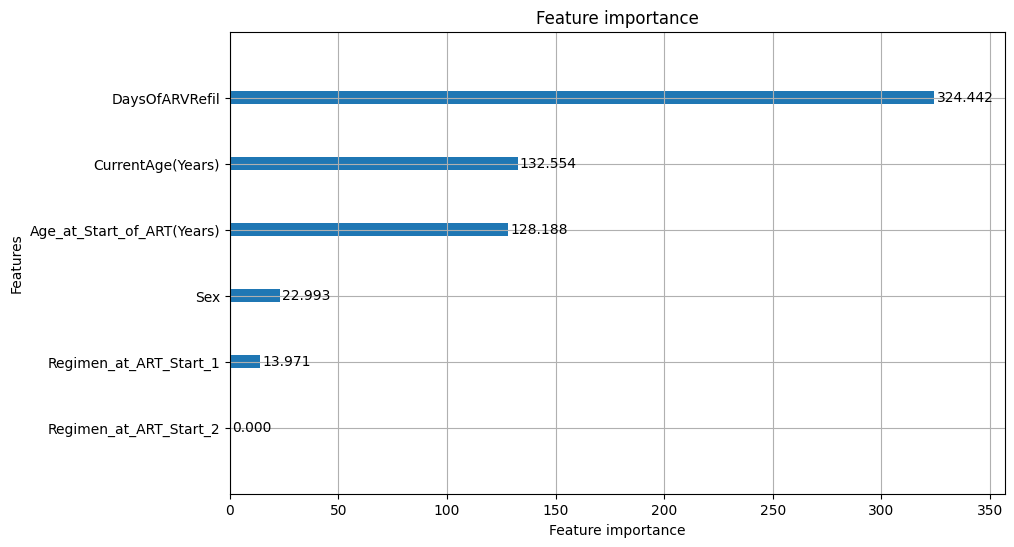

In [114]:
# show variable importance
lgb.plot_importance(model , importance_type='gain', figsize=(10, 6), max_num_features=10)
plt.show()

With about 80% accuracy, model is good to push into production

In [117]:
# Save model using pickle 
with open("ART Prediction Model", "wb") as f:
    pickle.dump(model, f) 


THANK YOU